In [4]:
sys.argv[1] = '-1'
sys.argv[2] = '-1'
sys.argv += '1'

Map properties
CMB experiment properties
CMB lensing power spectrum
Gets a theoretical prediction for the noise
computing the reconstruction noise
cmb0F_1 (10, 800, 401)
kCmbF_1 (10, 800, 401)
lCmbF_1 (10, 800, 401)
lCmbF_o1_1 (10, 800, 401)
lCmbF_o2_1 (10, 800, 401)
lCmbF_o3_1 (10, 800, 401)
lCmbF_o4_1 (10, 800, 401)
fgF_1 (10, 800, 401)
noiseF_1 (10, 800, 401)
totalF_1 (10, 800, 401)
totalF_0 (10, 800, 401)
[-1, -1] ['lCmbF_1', 'lCmbF_1']


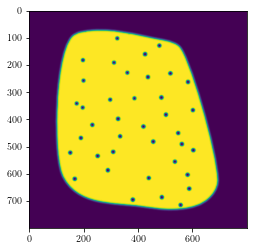

In [9]:
#######
IN_DATA_FNAMES = ['/oak/stanford/orgs/kipac/users/delon/LensQuEst/map_sims_800x800_20x20_%d.pkl'%(i) for i in range(1,51)]
DATA_FNAME = '/data/delon/LensQuEst/QE_and_Nhat_from_map_sims_800x800_20x20_Clunlensed_weight_masked.pkl'

mask_file = 'mask_simple800x800.png'
psfile = 'point_sources_800x800.png'
psapod = 2


template_name = mask_file.split('/')[-1].split('.')[0]
mean_field_file = '%s_point_sources.pkl'%(template_name)

pairs = [
#    [0,0], #N0
#    [0,1], #kappa
#    [1,0], #kappa
#    [0,2], #N1
#    [1,1], #N1
#    [2,0], #N1
#     [0,3], #should vanish
#     [1,2], #should vanish
#     [2,1], #should vanish
#     [3,0], #should vanish
#     [0,4], #N2 
#     [1,3], #N2
#     [2,2], #N2
#     [3,1], #N2
#     [4,0], #N2
   [-1, -1], #QE
   [-2, -2], #unlensed
]


import warnings
warnings.filterwarnings("ignore")
#####


# In[3]:


import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))


# In[4]:


from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr


# In[5]:


print("Map properties")

# number of pixels for the flat map
nX = 800
nY =800

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra


# In[6]:


print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: cmb.ftotal(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)


# In[7]:


print("CMB lensing power spectrum")
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)


# In[8]:


print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 


# In[9]:

#https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
from scipy.ndimage import gaussian_filter 
from scipy.fft import fft2

mask = rgb2gray(plt.imread(mask_file))
apodized_mask = gaussian_filter(mask, 3)
point_sources = rgb2gray(plt.imread(psfile))
point_sources = gaussian_filter(point_sources, psapod) 
apodized_mask += point_sources
nPos = np.where(apodized_mask>1)
apodized_mask[nPos] = 1
mask = 1-mask
apodized_mask = 1 - apodized_mask

for a in apodized_mask:
    for b in a:
        assert(b<=1 and b>=0)
        
plt.imshow(apodized_mask)
plt.savefig('figures/apodized_masked_%dx%d.pdf'%(nX, nY),bbox_inches='tight')

in_data = {}
file_idx = eval(sys.argv[3])
fname = IN_DATA_FNAMES[file_idx-1]
f = open(fname, 'rb') 
c_in_data = pickle.load(f) 
f.close()
for key in c_in_data:
    if(key not in in_data.keys()):
        in_data[key] = np.array(c_in_data[key])
    else:
        in_data[key] = np.vstack( (in_data[key],np.array(c_in_data[key])) )

for key in in_data:
    print(key, np.shape(in_data[key]))


# In[30]:



data_names = {
    0: 'cmb0F_1',
    1: 'lCmbF_o1_1',
    2: 'lCmbF_o2_1',
    3: 'lCmbF_o3_1',
    4: 'lCmbF_o4_1',
    -1: 'lCmbF_1',
    -2: 'totalF_0',
}


# In[ ]:


from tqdm import trange, tqdm

fgFourier = in_data['fgF_1']
noiseFourier = in_data['noiseF_1']


# In[43]:


fgFourier = in_data['fgF_1']
noiseFourier = in_data['noiseF_1']

pair = [eval(sys.argv[1]), eval(sys.argv[2])]
data = {}

mean_field = pickle.load(open(mean_field_file, 'rb'))


pair_key = '%d%d'%(pair[0],pair[1])
keys = [data_names[p] for p in pair]
print(pair, keys)
N_data = min(len(in_data[keys[0]]), len(in_data[keys[1]]))

c_data = []
c_data_sqrtN = []
c_data_kR  = []


In [10]:
for data_idx in trange(N_data):
    dataF0 = in_data[keys[0]][data_idx]
    if(pair[0]-1 >= 0):  #isolate term
        dataF0 = dataF0 - in_data[data_names[pair[0]-1]][data_idx]
    dataF1 = in_data[keys[1]][data_idx]
    if(pair[1]-1>=0):    #isolate term
        dataF1 = dataF1 - in_data[data_names[pair[1]-1]][data_idx]
    
    if(pair[0]!=-2):
        dataF0 = dataF0 + fgFourier[data_idx] + noiseFourier[data_idx]
        dataF1 = dataF1 + fgFourier[data_idx] + noiseFourier[data_idx]
        
    dataF0 = baseMap.fourier(baseMap.inverseFourier(dataF0)*apodized_mask)
    dataF1 = baseMap.fourier(baseMap.inverseFourier(dataF1)*apodized_mask)

    QE = baseMap.computeQuadEstKappaNorm(cmb.funlensedTT, cmb.fCtotal, 
                                         lMin=lMin, lMax=lMax, 
                                         dataFourier=dataF0,
                                         dataFourier2=dataF1)
    sqrtNhat = []
    kR = []
    if(pair[0]==pair[1]):
        sqrtNhat = baseMap.computeQuadEstKappaAutoCorrectionMap(cmb.funlensedTT,
                                                                cmb.fCtotal, 
                                                                lMin=lMin, lMax=lMax, 
                                                                dataFourier=dataF0)

        if(len(c_data_sqrtN)==0):
            c_data_sqrtN = np.array([sqrtNhat])
        else:
            c_data_sqrtN = np.vstack((c_data_sqrtN, np.array([sqrtNhat])))


    if(len(c_data)==0):
        c_data = np.array([QE])
    else:
        c_data = np.vstack((c_data, np.array([QE])))
        
        
    assert(len(c_data)==data_idx+1)


data[pair_key+'_m'] = c_data
data[pair_key+'_m'+'_sqrtN'] = c_data_sqrtN
f = open('/oak/stanford/orgs/kipac/users/delon/LensQuEst/QE_and_Nhat_from_map_sims_800x800_20x20_Clunlensed_weight_FILE%d_pair_%d_%d_MASKED.pkl'%(file_idx, pair[0], pair[1]), 'wb') 
pickle.dump(data, f)
f.close()

100%|██████████| 10/10 [02:35<00:00, 15.55s/it]
